# Exponential Smoothing

Libraries and Data

In [2]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [12]:
# import csv dataset
df=pd.read_csv('divvy-tripdata_cleaned.csv',index_col='start_time',parse_dates=True)

# make into dataframe
df2=pd.DataFrame(df)

# which columns to include alongside column acting as index
cols=[3]
df2=df2[df2.columns[cols]]

In [13]:
# sorting the dataframe
df3=df2.sort_values("start_time")
df3.head()

,trip_duration
start_time,
2013-06-30 10:48:00,557
2013-06-30 10:51:00,12496
2013-06-30 11:27:00,699
2013-06-30 11:35:00,1093
2013-06-30 11:56:00,3957


In [25]:
# index
# df3=df3.asfreq("T")
# df3.index

Model: Exponential Smoothing

In [26]:
model = ExponentialSmoothing(endog = df3.trip_duration).fit()

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Predictions and Plotting: Exponential Smoothing

In [27]:
predictions=model.forecast(steps=100)

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='start_time'>

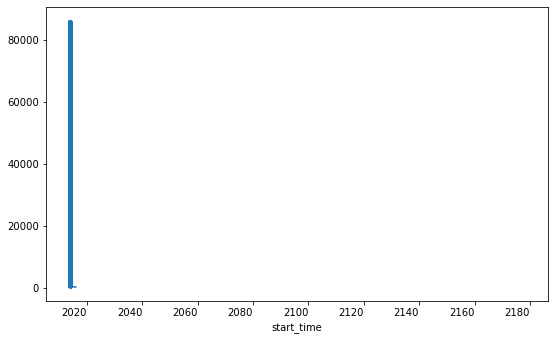

In [28]:
df3['trip_duration'].plot(figsize=(9,6))
predictions.plot()

Model: Holt-Winters

In [29]:
model2=ExponentialSmoothing(endog=df3.trip_duration, 
                            trend='add', 
                            seasonal='add', 
                            seasonal_periods=7).fit()

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Predictions and Plotting: Holt-Winters

In [30]:
predictions2=model2.forecast(steps=100)

C:\Users\TAMOJIT\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='start_time'>

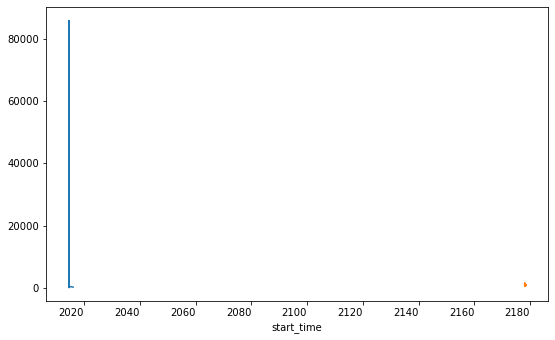

In [31]:
df3['trip_duration']['2014-06-30 10:51:00':].plot(figsize=(9,6))
predictions2.plot()